# Terence's Capstone Project  
## How to select neighbourhoods for your first rental property in Sydney  (10/12/2019)
[Link to the project paper](https://github.com/tianruisun/IBM-Data-Scientist-Certification/blob/master/Tianrui%20Sun's%20Capstone%20Project%20Week%205.pdf)  

In [5]:
# Add all necessary libraries required by this project
#install folium geopy and xlrd 
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#!conda install -c anaconda xlrd --yes
import numpy as np
import matplotlib.pyplot as plt
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#set display row for dataframe 
pd.set_option("display.max_rows", 200)

#pip install feature-selector
#pip install numpy --upgrade

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    scipy-1.3.2                |   py36h921218d_0        18.0 MB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    numpy-1.17.3               |   py36h95a1406_0         5.2 MB  conda-forge

### Import all required data
[Data can be find here](https://github.com/tianruisun/IBM-Data-Scientist-Certification)

In [9]:
Australian_Post_Codes_Lat_Lon=pd.read_csv('Australian_Post_Codes_Lat_Lon.csv')
Rent_Tables_Jun_Quarter_2019=pd.read_excel('Rent_Tables_Jun_Quarter_2019_Modified.xlsx')
SydneyMetro_Postcodes=pd.read_excel('SydneyMetro_Postcodes_Modified.xlsx')
Neighbourhood_venues=pd.read_csv('Neighbourhood_venues.csv')
Venue_Group=pd.read_excel('Venue_Group.xlsx')
Postcode_Crime_2018=pd.read_excel('PostcodeData2018_Modified.xlsx')

## Data Preparation Section

In [10]:
#Import required data and rename column to form same standard

Australian_Post_Codes_Lat_Lon = Australian_Post_Codes_Lat_Lon[Australian_Post_Codes_Lat_Lon.postcode != 0]
Australian_Post_Codes_Lat_Lon.rename(columns={"suburb":"neighbourhood"}, inplace=True)
Australian_Post_Codes_Lat_Lon.drop(columns=['state', 'type','dc'], inplace=True)
Australian_Post_Codes_Lat_Lon.head()

#Originally thought we have duplicated by postcode and suburb, and try to pick up the first records.
#Australian_Post_Codes_Lat_Lon.sort_values(['postcode', 'suburb','address_type'], ascending=[True, True,True], inplace=True)
#Australian_Post_Codes_Lat_Lon1 = Australian_Post_Codes_Lat_Lon.groupby(['postcode', 'suburb']).head(1)

,postcode,neighbourhood,lat,lon
0,200,AUSTRALIAN NATIONAL UNIVERSITY,-35.277272,149.117136
1,221,BARTON,-35.201372,149.095065
2,800,DARWIN,-12.801028,130.955789
3,801,DARWIN,-12.801028,130.955789
4,804,PARAP,-12.432181,130.843310


In [11]:
SydneyMetro_Postcodes.head()

,Suburb,Postcode,Area
0,Sydney City,2000,Central & Inner Metropolitan
1,Ultimo,2007,Central & Inner Metropolitan
2,Chippendale,2008,Central & Inner Metropolitan
3,Pyrmont,2009,Central & Inner Metropolitan
4,Surry Hills,2010,Central & Inner Metropolitan


In [12]:
SydneyMetro_Postcodes.rename(columns={"Suburb": "suburb",  "Postcode": "postcode","Area": "area"}, inplace=True)
SydneyMetro_Postcodes.shape

(202, 3)

In [13]:
#I have remove all records that do not have rental price info, as they will not included in this analysis task
Rent_Tables_Jun_Quarter_2019.rename(columns={"Postcode": "postcode",  "Dwelling_Types": "dwelling","Bedroom_Numbers": "bedroom_no",
                                             "First_Quartile_Weekly_Rent": "fq_rent", "Median_Quartile_Weekly_Rent": "median_rent", 
                                             "Third_Quartile_Weekly_Rent": "tq_rent", "New_Bonds_Lodged": "new_bonds",
                                             "Total_Bonds_Held": "total_bonds","Annual_change_in_Median_Weekly_Rent": "annual_median_rent_change"}, inplace=True)
Rent_Tables_Jun_Quarter_20191=Rent_Tables_Jun_Quarter_2019.query('dwelling=="Flat/Unit" & bedroom_no in ("2 Bedrooms","3 Bedrooms")')
Rent_Tables_Jun_Quarter_20192=Rent_Tables_Jun_Quarter_20191.query('fq_rent!="-"')

#Rent_Tables_Jun_Quarter_20192['annual_median_rent_change'] = pd.Series(["{0:.2f}%".format(val * 100) for val in Rent_Tables_Jun_Quarter_20192['annual_median_rent_change']], index = Rent_Tables_Jun_Quarter_20192.index)

In [14]:
Rent_Tables_Jun_Quarter_20192.head()

,postcode,dwelling,bedroom_no,fq_rent,median_rent,tq_rent,new_bonds,total_bonds,annual_median_rent_change
51,2000,Flat/Unit,2 Bedrooms,830,915,1050,394,2731,-0.0343
52,2000,Flat/Unit,3 Bedrooms,1200,1380,1650,41,353,0.0222
84,2007,Flat/Unit,2 Bedrooms,678,780,830,44,536,-0.037
119,2008,Flat/Unit,2 Bedrooms,708,885,1050,42,647,0.18
151,2009,Flat/Unit,2 Bedrooms,720,780,890,126,1326,-0.0429


#### The scope of this analysis it limited to Sydney Metro area only. We will use the Sydney Metro Postcode file to limite the data for other 2 files which give you property rent and Geo Coordinates for all Australia areas

In [15]:
Sydney_Geo = pd.merge(left=SydneyMetro_Postcodes,right=Australian_Post_Codes_Lat_Lon, left_on='postcode', right_on='postcode')
Sydney_Geo.head()

,suburb,postcode,area,neighbourhood,lat,lon
0,Sydney City,2000,Central & Inner Metropolitan,DAWES POINT,-33.855601,151.208220
1,Sydney City,2000,Central & Inner Metropolitan,HAYMARKET,-33.880777,151.202796
2,Sydney City,2000,Central & Inner Metropolitan,MILLERS POINT,-33.858315,151.203519
3,Sydney City,2000,Central & Inner Metropolitan,PARLIAMENT HOUSE,-33.867229,151.213051
4,Sydney City,2000,Central & Inner Metropolitan,SYDNEY,-33.867139,151.207114


In [16]:
Sydney_Geo_Rent = pd.merge(left=Sydney_Geo,right=Rent_Tables_Jun_Quarter_20192, left_on='postcode', right_on='postcode')
Sydney_Geo_Rent.head()

,suburb,postcode,area,neighbourhood,lat,lon,dwelling,bedroom_no,fq_rent,median_rent,tq_rent,new_bonds,total_bonds,annual_median_rent_change
0,Sydney City,2000,Central & Inner Metropolitan,DAWES POINT,-33.855601,151.208220,Flat/Unit,2 Bedrooms,830,915,1050,394,2731,-0.0343
1,Sydney City,2000,Central & Inner Metropolitan,DAWES POINT,-33.855601,151.208220,Flat/Unit,3 Bedrooms,1200,1380,1650,41,353,0.0222
2,Sydney City,2000,Central & Inner Metropolitan,HAYMARKET,-33.880777,151.202796,Flat/Unit,2 Bedrooms,830,915,1050,394,2731,-0.0343
3,Sydney City,2000,Central & Inner Metropolitan,HAYMARKET,-33.880777,151.202796,Flat/Unit,3 Bedrooms,1200,1380,1650,41,353,0.0222
4,Sydney City,2000,Central & Inner Metropolitan,MILLERS POINT,-33.858315,151.203519,Flat/Unit,2 Bedrooms,830,915,1050,394,2731,-0.0343


In [17]:
#To save the time to run the project a few time, I have store some clean table into csv at certain stage
#project.save_data(data=Sydney_Geo_Rent.to_csv(index=False),file_name='Afterprep.csv',overwrite=True)

## Data Exploratory Analysis

### How is Sydney rental price looks like?

In [18]:
Sydney_Geo_Rent["fq_rent"] = Sydney_Geo_Rent.fq_rent.astype(float)
Sydney_Geo_Rent["median_rent"] = Sydney_Geo_Rent.median_rent.astype(float)
Sydney_Geo_Rent["tq_rent"] = Sydney_Geo_Rent.tq_rent.astype(float)
Sydney_Geo_Rent["total_bonds"] = Sydney_Geo_Rent.total_bonds.astype(int)
Sydney_Geo_Rent["annual_median_rent_change"] = Sydney_Geo_Rent.annual_median_rent_change.astype(float)
Sydney_Geo_Rent.drop(columns="new_bonds",inplace=True)

#Our rental and crime data are all on postcode level and our Geo data is on neighbourhood level.  For below descriptive analysis on postcode level, we need to selected on distinct records on postcode
Sydney_Geo_Rent.dtypes
Postcode_Geo_Rent=Sydney_Geo_Rent.groupby(['postcode','bedroom_no']).first()

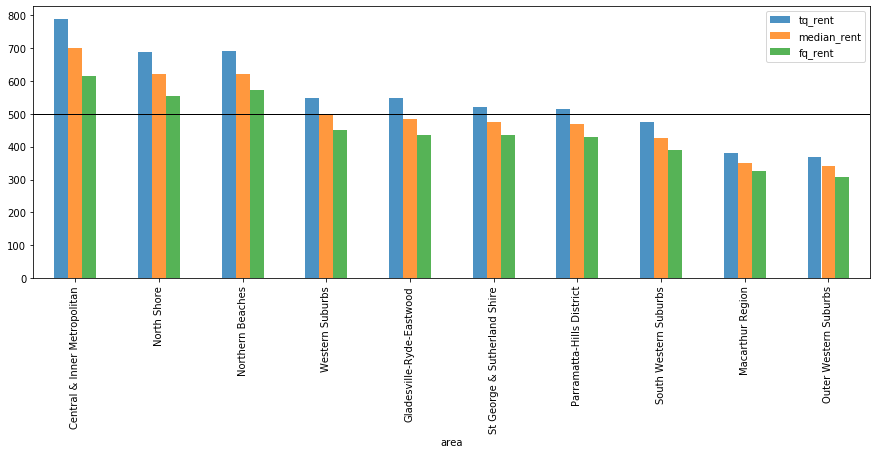

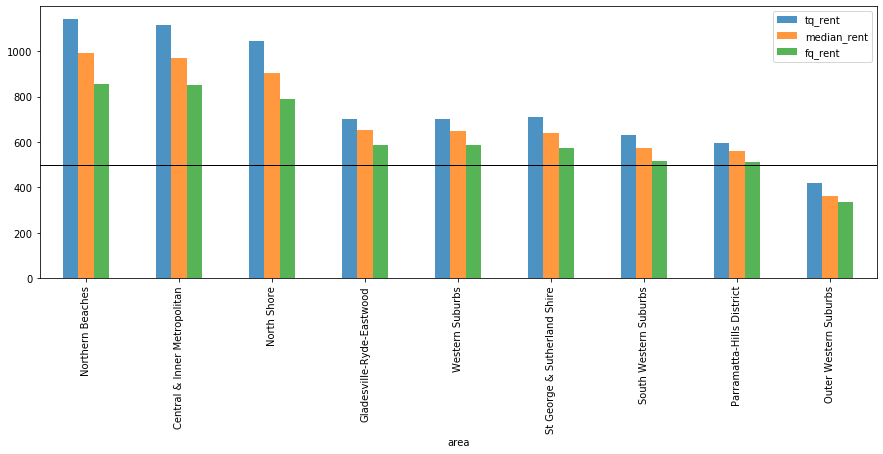

In [19]:
df2 = Postcode_Geo_Rent.query('bedroom_no in ("2 Bedrooms")').groupby(['area'])['tq_rent','median_rent','fq_rent'].mean().sort_values(['median_rent'],ascending=False)
df2.plot.bar(figsize=(15,5), alpha=0.8)
plt.axhline(y=500,linewidth=1, color='k')
    
df3 = Postcode_Geo_Rent.query('bedroom_no in ("3 Bedrooms")').groupby(['area'])['tq_rent','median_rent','fq_rent'].mean().sort_values(['median_rent'],ascending=False)
df3.plot.bar(figsize=(15,5), alpha=0.8)
plt.axhline(y=500,linewidth=1, color='k')

In [110]:
Postcode_Geo_Rent.query('bedroom_no in ("2 Bedrooms")').head()

,,suburb,area,neighbourhood,lat,lon,dwelling,fq_rent,median_rent,tq_rent,total_bonds,annual_median_rent_change
postcode,bedroom_no,,,,,,,,,,,
2000,2 Bedrooms,Sydney City,Central & Inner Metropolitan,DAWES POINT,-33.855601,151.208220,Flat/Unit,830.0,915.0,1050.0,2731,-0.0343
2007,2 Bedrooms,Ultimo,Central & Inner Metropolitan,BROADWAY,-33.884366,151.196502,Flat/Unit,678.0,780.0,830.0,536,-0.0370
2008,2 Bedrooms,Chippendale,Central & Inner Metropolitan,CHIPPENDALE,-33.886844,151.201715,Flat/Unit,708.0,885.0,1050.0,647,0.1800
2009,2 Bedrooms,Pyrmont,Central & Inner Metropolitan,PYRMONT,-33.869709,151.193930,Flat/Unit,720.0,780.0,890.0,1326,-0.0429
2010,2 Bedrooms,Surry Hills,Central & Inner Metropolitan,DARLINGHURST,-33.879825,151.219560,Flat/Unit,680.0,765.0,895.0,1697,-0.0437


### Which area are in Sydney are popular among tenants?

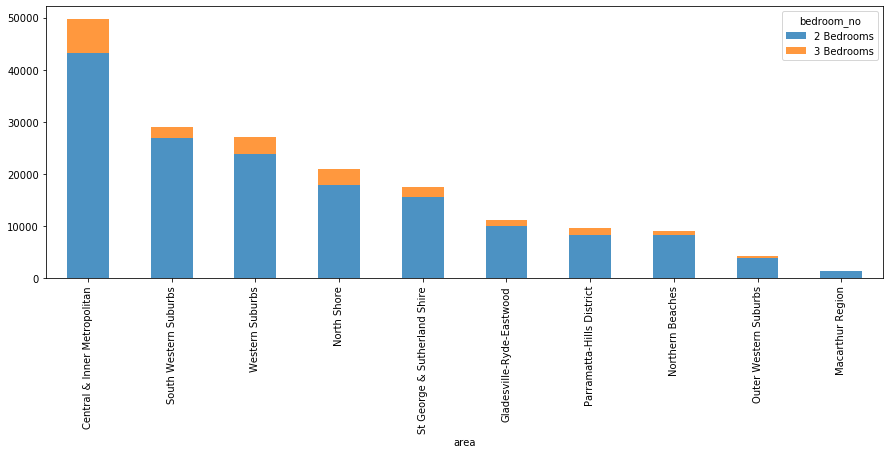

In [111]:
df4 = Postcode_Geo_Rent.groupby(['area','bedroom_no'])['total_bonds'].sum().unstack('bedroom_no')
#df4.plot.bar(stacked=True)
s_sort = Postcode_Geo_Rent.groupby(['area'])['total_bonds'].sum().sort_values(ascending=False)
s_sort

df4.reindex(index=s_sort.index).plot.bar(stacked=True,figsize=(15,5), alpha=0.8)

In [21]:
Top10_2beds_Geo_Rent=Postcode_Geo_Rent.query('bedroom_no in ("2 Bedrooms")').sort_values(by='total_bonds', ascending=False).head(10)
Top10_3beds_Geo_Rent=Postcode_Geo_Rent.query('bedroom_no in ("3 Bedrooms")').sort_values(by='total_bonds', ascending=False).head(10)

### Top 10 most popular suburb in Sydney for rental properties.

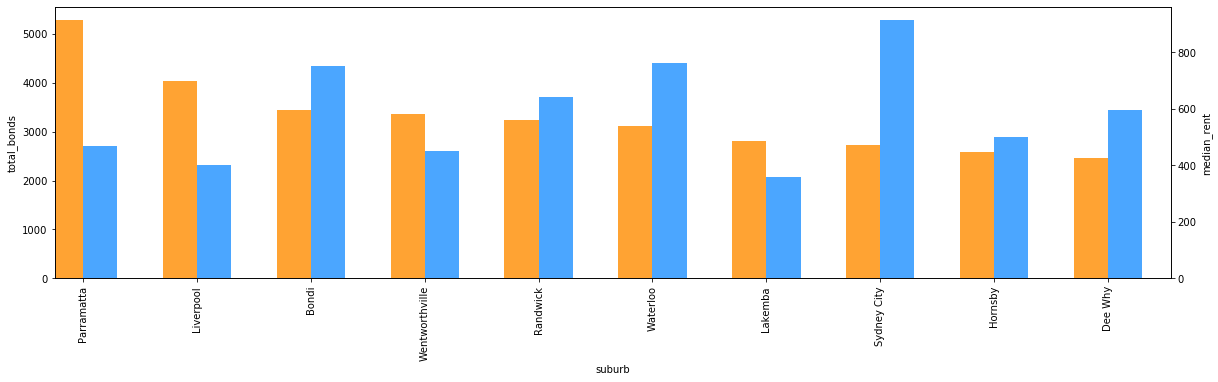

In [22]:
Top10_2beds_Geo_Rent.reset_index(inplace=True)

df5 =Top10_2beds_Geo_Rent[['suburb','total_bonds','median_rent']]
df5.set_index('suburb', inplace=True)

fig = plt.figure(figsize=(20,5)) 

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.3

df5.total_bonds.plot(kind='bar', color='darkorange', ax=ax, width=width, position=1,alpha=0.8)
df5.median_rent.plot(kind='bar', color='dodgerblue', ax=ax2, width=width, position=0,alpha=0.8)

ax.set_ylabel('total_bonds')
ax2.set_ylabel('median_rent')


plt.show()

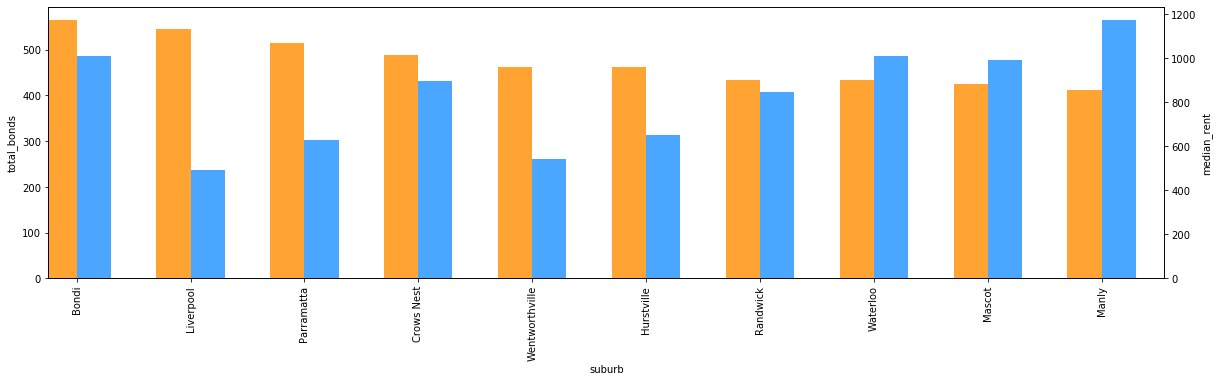

In [114]:
Top10_3beds_Geo_Rent.reset_index(drop=True, inplace=True)

df6 =Top10_3beds_Geo_Rent[['suburb','total_bonds','median_rent']]
df6.set_index('suburb', inplace=True)

fig = plt.figure(figsize=(20,5)) 

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.3

df6.total_bonds.plot(kind='bar', color='darkorange', ax=ax, width=width, position=1,alpha=0.8)
df6.median_rent.plot(kind='bar', color='dodgerblue', ax=ax2, width=width, position=0,alpha=0.8)

ax.set_ylabel('total_bonds')
ax2.set_ylabel('median_rent')


plt.show()

In [23]:
Asian_2beds_Geo_Rent=Postcode_Geo_Rent.query('bedroom_no in ("2 Bedrooms") and postcode in (2220,2134,2067,2131)')
Asian_2beds_Geo_Rent

,,suburb,area,neighbourhood,lat,lon,dwelling,fq_rent,median_rent,tq_rent,total_bonds,annual_median_rent_change
postcode,bedroom_no,,,,,,,,,,,
2067,2 Bedrooms,Chatswood,North Shore,CHATSWOOD,-33.795617,151.185329,Flat/Unit,578.0,680.0,820.0,1508,0.0000
2131,2 Bedrooms,Ashfield,Western Suburbs,ASHFIELD,-33.889498,151.127444,Flat/Unit,450.0,490.0,550.0,2239,-0.0200
2134,2 Bedrooms,Burwood,Western Suburbs,BURWOOD,-33.877423,151.103682,Flat/Unit,538.0,620.0,676.0,1106,-0.0159
2220,2 Bedrooms,Hurstville,St George & Sutherland Shire,HURSTVILLE,-33.965923,151.101184,Flat/Unit,490.0,530.0,580.0,2039,0.0000


In [24]:
Sydney_2beds_Geo_Rent=Sydney_Geo_Rent.query('bedroom_no in ("2 Bedrooms")')
Sydney_2beds_Geo_Rent.head()

,suburb,postcode,area,neighbourhood,lat,lon,dwelling,bedroom_no,fq_rent,median_rent,tq_rent,total_bonds,annual_median_rent_change
0,Sydney City,2000,Central & Inner Metropolitan,DAWES POINT,-33.855601,151.208220,Flat/Unit,2 Bedrooms,830.0,915.0,1050.0,2731,-0.0343
2,Sydney City,2000,Central & Inner Metropolitan,HAYMARKET,-33.880777,151.202796,Flat/Unit,2 Bedrooms,830.0,915.0,1050.0,2731,-0.0343
4,Sydney City,2000,Central & Inner Metropolitan,MILLERS POINT,-33.858315,151.203519,Flat/Unit,2 Bedrooms,830.0,915.0,1050.0,2731,-0.0343
6,Sydney City,2000,Central & Inner Metropolitan,PARLIAMENT HOUSE,-33.867229,151.213051,Flat/Unit,2 Bedrooms,830.0,915.0,1050.0,2731,-0.0343
8,Sydney City,2000,Central & Inner Metropolitan,SYDNEY,-33.867139,151.207114,Flat/Unit,2 Bedrooms,830.0,915.0,1050.0,2731,-0.0343


### In 2019, how is Sydney rental price changes look like by Neighbourhood? 

In [25]:
Sydney_2beds_Geo_Rent1=Sydney_2beds_Geo_Rent.copy()
#Sydney_2beds_Geo_Rent1['Rental_Change_Percentile']=Sydney_2beds_Geo_Rent.annual_median_rent_change.rank(pct=True)

#split the rental change in 5 groups. 

#drop by 10% or more
#drop by 3% to 10%
#between 3% drop and 3% increase <== common flutuaction
#% to 10% increase
#increase more than 10%

Sydney_2beds_Geo_Rent1['Rental_Change_Color'] = np.select(
    [
        Sydney_2beds_Geo_Rent1['annual_median_rent_change'] <-0.1,  
        Sydney_2beds_Geo_Rent1['annual_median_rent_change'] <-0.03,  
        Sydney_2beds_Geo_Rent1['annual_median_rent_change'] <0.03,
        Sydney_2beds_Geo_Rent1['annual_median_rent_change'] <0.1,
       #np.logical_and(Sydney_2beds_Geo_Rent1['Rental_Change_Percentile']<=1, Sydney_2beds_Geo_Rent1['annual_median_rent_change'] >0)
    ], 
    [
        'red',
        'orange',
        'blue',
        'green',

    ],
     default='lime'
)
Sydney_2beds_Geo_Rent2= Sydney_2beds_Geo_Rent1.style.format({
    'annual_median_rent_change': '{:,.2%}'.format,
})

In [26]:
address = 'Sydney, Australia'

#-33.876295,151.1985883,

geolocator = Nominatim(user_agent="sydney_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [27]:
#plot the rental changes on folium map
map_rental_change = folium.Map(width=2000,height=2000,location=[latitude, longitude], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,color in zip(Sydney_2beds_Geo_Rent1['lat'], Sydney_2beds_Geo_Rent1['lon'], Sydney_2beds_Geo_Rent1['neighbourhood'], round(Sydney_2beds_Geo_Rent1['annual_median_rent_change'], 2), Sydney_2beds_Geo_Rent1['Rental_Change_Color']):
    label = folium.Popup(str(poi)  +'  '+ str(cluster) + '%', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7).add_to(map_rental_change)
       
map_rental_change

### How is Sydney Neighbourhood Safety look like?

In [30]:
Postcode_Crime_2018
Postcode_Crime_2018['Crime_Group'] = np.select(
    [
        Postcode_Crime_2018['Offence category']=="Theft", 
    ], 
    [
        'Theft'
    ], 
    default='Major Crime'
)

Postcode_Crime_20181=Postcode_Crime_2018.copy()

In [31]:
# we create a column bu sumarrise all different major type of crime by postcode in Sydney
Postcode_Crime_20181['total'] = Postcode_Crime_20181.drop('Postcode', axis=1).sum(axis=1)
Postcode_Crime_20182 = Postcode_Crime_20181.groupby(['Postcode','Crime_Group'])['total'].sum().reset_index()
Postcode_Crime_20183=Postcode_Crime_20182.pivot(index='Postcode', columns='Crime_Group', values='total').fillna(0)
Postcode_Crime_20183['total']= Postcode_Crime_20183.sum(axis=1)

In [33]:
# join the crime data with geo data to be prepared to show on the map
Sydney_Geo_Rent_Crime = pd.merge(left=Sydney_2beds_Geo_Rent,right=Postcode_Crime_20183, left_on='postcode', right_on='Postcode')
Sydney_Geo_Rent_Crime1=Sydney_Geo_Rent_Crime

In [34]:
#split the crime count into 5 group based on precential ranking. 

#top 15%  is very low risk
#15% to 40 is low risk
#between 30% and 70% medium risk
#70% to 85% high risk
#bottom 15%, very high risk

Sydney_Geo_Rent_Crime1['Percentile_rank']=Sydney_Geo_Rent_Crime1.total.rank(pct=True)
Sydney_Geo_Rent_Crime1

Sydney_Geo_Rent_Crime1['Crime_Severity'] = np.select(
    [
        Sydney_Geo_Rent_Crime1['Percentile_rank']<=0.15, 
        Sydney_Geo_Rent_Crime1['Percentile_rank']<=0.3,
        Sydney_Geo_Rent_Crime1['Percentile_rank']<=0.7,
        Sydney_Geo_Rent_Crime1['Percentile_rank']<=0.85,
        Sydney_Geo_Rent_Crime1['Percentile_rank']<=1,
    ], 
    [
        'Very Low Risk',
        'Low Risk',
        'Medium Risk',
        'High Risk',
        'Very High Risk',
    ]
)

Sydney_Geo_Rent_Crime1['Crime_Severity_Color'] = np.select(
    [
        Sydney_Geo_Rent_Crime1['Percentile_rank']<=0.15, 
        Sydney_Geo_Rent_Crime1['Percentile_rank']<=0.3,
        Sydney_Geo_Rent_Crime1['Percentile_rank']<=0.7,
        Sydney_Geo_Rent_Crime1['Percentile_rank']<=0.85,
        Sydney_Geo_Rent_Crime1['Percentile_rank']<=1,
    ], 
    [
        'lime',
        'green',
        'blue',
        'orange',
        'red',
    ]
)

In [35]:
map_crime = folium.Map(width=2000,height=2000,location=[latitude, longitude], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,color in zip(Sydney_Geo_Rent_Crime1['lat'], Sydney_Geo_Rent_Crime1['lon'], Sydney_Geo_Rent_Crime1['neighbourhood'], Sydney_Geo_Rent_Crime1['Crime_Severity'], Sydney_Geo_Rent_Crime1['Crime_Severity_Color']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7).add_to(map_crime)
       
map_crime

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


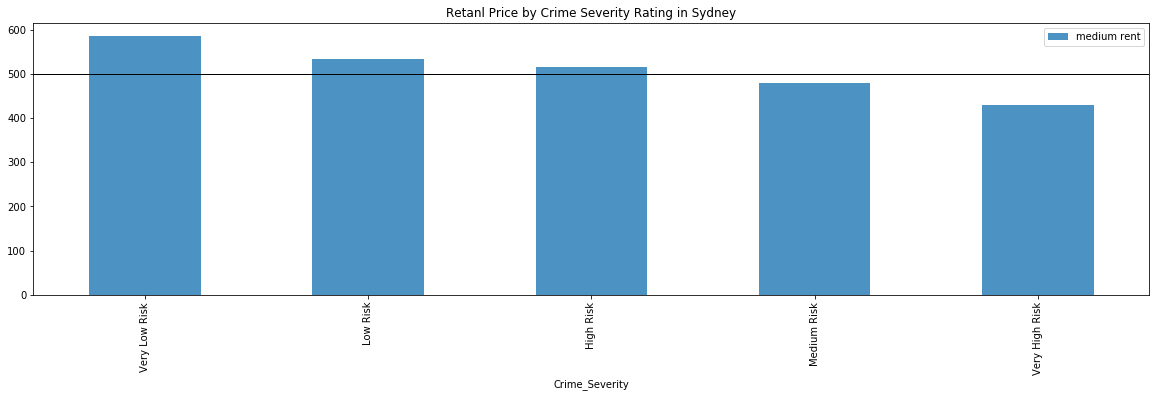

In [36]:
#Is there any link between neighbour security compare to rental price?
rental_by_crime = Sydney_Geo_Rent_Crime1.groupby(['Crime_Severity'])['median_rent'].mean().sort_values(ascending=False)
rental_by_crime.plot.bar(figsize=(20,5), alpha=0.8)
plt.legend(['medium rent'], loc='upper right')
plt.axhline(y=500,linewidth=1, color='k')
#plt.grid()
ax = plt.subplot() 
ax.set_title('Retanl Price by Crime Severity Rating in Sydney')
plt.show()

In [38]:
# @hidden_cell
#Foursquare connection details

In [39]:
Postcode_Geo_Rent.reset_index(inplace=True)

In [40]:
neighbourhood_latitude = Postcode_Geo_Rent.loc[0, 'lat'] # neighborhood latitude value
neighbourhood_longitude = Postcode_Geo_Rent.loc[0, 'lon'] # neighborhood longitude value
neighbourhood_name = Postcode_Geo_Rent.loc[0, 'neighbourhood'] # neighborhood name
print('Latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name, 
                                                               neighbourhood_latitude, 
                                                               neighbourhood_longitude))

Latitude and longitude values of DAWES POINT are -33.855601, 151.20821999999998.


In [41]:
#Setup the test call to see how return of foursquare API lookslike
LIMIT = 5 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighbourhood_latitude, 
    neighbourhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=NSPUIICKMNY53FY0NCWY03QPSYTIPRGQLPPSRBLITBDDMBD4&client_secret=ZIFRKEW14TSEMZO4SJMHIWBYYQGHRMJYBU2GBGE2F14CHCSQ&v=20180605&ll=-33.855601,151.20821999999998&radius=1000&limit=5'

In [42]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5def4e4f40a7ea450cc1f280'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Central Business District',
  'headerFullLocation': 'Central Business District, Sydney',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 189,
  'suggestedBounds': {'ne': {'lat': -33.84660099099999,
    'lng': 151.21903734877398},
   'sw': {'lat': -33.86460100900001, 'lng': 151.19740265122599}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4d97e60e2bd6f04ddd795c50',
       'name': 'Harbour Bridge Pylon Lookout',
       'location': {'address': 'Bradfield Hwy.',
        'lat': -33.85457956213469,
        'lng': 151.20949211611202,
        'labeledLatLngs

### Setup class to extract foursquare API JSON return into a dataframe

In [43]:
#Setup class to extract foursquare API JSON return into a dataframe
def getNearbyVenues(names, latitudes, longitudes, postcode, radius=600):
    
    venues_list=[]
    for name, lat, lng, post in zip(names, latitudes, longitudes, postcode):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}'.format(   #&limit={}
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            post,
            v['venue']['name'],
            v['venue']['id'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['location'].get('postalCode',''), 
            v['venue']['location'].get('distance',''), 
            v['venue']['location'].get('neighborhood',''),  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['neighbourhood',    
                  'neighbourhood_lat', 
                  'neighbourhood_lon', 
                  'neighbourhood_postcode', 
                  'venue', 
                  'venue_id',  
                  'venue_lat', 
                  'venue_lon', 
                  'venue_postcode', 
                  'venue_distance', 
                  'venue_neighbourhood', 
                  'venue_category']
    
    return(nearby_venues)

### Due to foursquare API has limits on API call daily for free user. I will just save the output into csv instead of calling it on daily basis for my analysis.

In [132]:
#Neighbourhood_venues = getNearbyVenues(names=Sydney_2beds_Geo_Rent['neighbourhood'],
#                                   latitudes=Sydney_2beds_Geo_Rent['lat'],
#                                   longitudes=Sydney_2beds_Geo_Rent['lon'],
#                                   postcode=Sydney_2beds_Geo_Rent['postcode']
#                                 )
#project.save_data(data=Neighbourhood_venues.to_csv(index=False),file_name='Neighbourhood_venues.csv',overwrite=True)

In [53]:
#We have get 9151 venues for all the Geo data we have supplied
Neighbourhood_venues.shape

(9151, 12)

In [54]:
#Merge the data to the venue group data created  by myself to get the high level group of venue
Neighbourhood_venues1 = pd.merge(left=Neighbourhood_venues,right=Venue_Group, left_on='venue_category', right_on='type')
Neighbourhood_venues1["venue_postcode"] = pd.to_numeric(Neighbourhood_venues1['venue_postcode'],errors='coerce')
Neighbourhood_venues1["neighbourhood_postcode"] = Neighbourhood_venues1.neighbourhood_postcode.fillna(0).astype(int)
Neighbourhood_venues1["venue_postcode"] = Neighbourhood_venues1.venue_postcode.fillna(0).astype(int)
Neighbourhood_venues1.head()

,neighbourhood,neighbourhood_lat,neighbourhood_lon,neighbourhood_postcode,venue,venue_id,venue_lat,venue_lon,venue_postcode,venue_distance,venue_neighbourhood,venue_category,type,group
0,DAWES POINT,-33.855601,151.208220,2000,Harbour Bridge Pylon Lookout,4d97e60e2bd6f04ddd795c50,-33.854580,151.209492,0,163,NaN,Scenic Lookout,Scenic Lookout,attractions
1,DAWES POINT,-33.855601,151.208220,2000,Dawes Point,4b18a60cf964a520f7d423e3,-33.855194,151.209820,2000,154,NaN,Scenic Lookout,Scenic Lookout,attractions
2,MILLERS POINT,-33.858315,151.203519,2000,Shangri-La Rooftop,523a3ce511d20d3b0ffc04a6,-33.861176,151.206333,2000,411,NaN,Scenic Lookout,Scenic Lookout,attractions
3,PARLIAMENT HOUSE,-33.867229,151.213051,2000,Skywalk On Sydney Tower,4d241e72836f5481e0a640f7,-33.870432,151.208871,2000,525,NaN,Scenic Lookout,Scenic Lookout,attractions
4,SYDNEY,-33.867139,151.207114,2000,Skywalk On Sydney Tower,4d241e72836f5481e0a640f7,-33.870432,151.208871,2000,400,NaN,Scenic Lookout,Scenic Lookout,attractions


In [55]:
#Neighbourhood_venues1['neighbourhood_postcode'] = np.where(Neighbourhood_venues1['venue_postcode'] != 0, Neighbourhood_venues1['venue_postcode'], Neighbourhood_venues1['neighbourhood_postcode'])
Neighbourhood_venues2 = pd.merge(left=Neighbourhood_venues1,right=SydneyMetro_Postcodes, left_on='neighbourhood_postcode', right_on='postcode')
Neighbourhood_venues2 = Neighbourhood_venues2[['neighbourhood','neighbourhood_postcode','suburb','area','neighbourhood_lat','neighbourhood_lon','venue','venue_id','venue_category','group']]
Neighbourhood_venues2.shape

(7658, 10)

In [56]:
Neighbourhood_venues2.head()

,neighbourhood,neighbourhood_postcode,suburb,area,neighbourhood_lat,neighbourhood_lon,venue,venue_id,venue_category,group
0,DAWES POINT,2000,Sydney City,Central & Inner Metropolitan,-33.855601,151.208220,Harbour Bridge Pylon Lookout,4d97e60e2bd6f04ddd795c50,Scenic Lookout,attractions
1,DAWES POINT,2000,Sydney City,Central & Inner Metropolitan,-33.855601,151.208220,Dawes Point,4b18a60cf964a520f7d423e3,Scenic Lookout,attractions
2,MILLERS POINT,2000,Sydney City,Central & Inner Metropolitan,-33.858315,151.203519,Shangri-La Rooftop,523a3ce511d20d3b0ffc04a6,Scenic Lookout,attractions
3,PARLIAMENT HOUSE,2000,Sydney City,Central & Inner Metropolitan,-33.867229,151.213051,Skywalk On Sydney Tower,4d241e72836f5481e0a640f7,Scenic Lookout,attractions
4,SYDNEY,2000,Sydney City,Central & Inner Metropolitan,-33.867139,151.207114,Skywalk On Sydney Tower,4d241e72836f5481e0a640f7,Scenic Lookout,attractions


In [57]:
#Transpose the data by venue group to see what types of venue we have for each neighbourhood
df7=Neighbourhood_venues2.groupby(['neighbourhood','neighbourhood_postcode','suburb','area','neighbourhood_lat','neighbourhood_lon','group']).count()
df8=df7.sort_values(by="neighbourhood",ascending=False)
df8.reset_index(inplace=True)
df8.head()

,neighbourhood,neighbourhood_postcode,suburb,area,neighbourhood_lat,neighbourhood_lon,group,venue,venue_id,venue_category
0,ZETLAND,2017,Waterloo,Central & Inner Metropolitan,-33.909938,151.206234,train,2,2,2
1,ZETLAND,2017,Waterloo,Central & Inner Metropolitan,-33.909938,151.206234,supermarket,1,1,1
2,ZETLAND,2017,Waterloo,Central & Inner Metropolitan,-33.909938,151.206234,shopping,2,2,2
3,ZETLAND,2017,Waterloo,Central & Inner Metropolitan,-33.909938,151.206234,restaurant,5,5,5
4,ZETLAND,2017,Waterloo,Central & Inner Metropolitan,-33.909938,151.206234,park,1,1,1


In [58]:
#df8=df8[["neighbourhood","group","venue_id"]]
df9=df8.pivot(index='neighbourhood', columns='group', values='venue_id').fillna(0)
df9.head()

group,attractions,bar,beach,food_other,hotel,other,park,restaurant,shopping,shopping_mall,sports,supermarket,train,transportation
neighbourhood,,,,,,,,,,,,,,
ABBOTSFORD,0.0,0.0,0.0,3.0,0.0,0.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0
AGNES BANKS,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AIRDS,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
ALEXANDRIA,0.0,5.0,0.0,12.0,0.0,3.0,1.0,10.0,6.0,0.0,0.0,1.0,0.0,0.0
ALLAMBIE HEIGHTS,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### We create a total venue number count for each neighbourhood and list the top 20 and bottom 20 neighbourhood by venue count to exam how the rental pricess look like

In [59]:
Sydney_2beds_Geo_Rent=Sydney_Geo_Rent.query('bedroom_no in ("2 Bedrooms")')
Neighbourhood_rent_venue = pd.merge(left=Sydney_2beds_Geo_Rent[['postcode','neighbourhood','median_rent']],right=df9, left_on='neighbourhood', right_on='neighbourhood',how='left')
print(Neighbourhood_rent_venue.shape)
Neighbourhood_rent_venue.fillna(0)
Neighbourhood_rent_venue['total_venue'] = Neighbourhood_rent_venue.drop(['postcode','median_rent'], axis=1).sum(axis=1)
Neighbourhood_rent_venue.sort_values(by="total_venue").tail(20)

(585, 17)


,postcode,neighbourhood,median_rent,attractions,bar,beach,food_other,hotel,other,park,restaurant,shopping,shopping_mall,sports,supermarket,train,transportation,total_venue
121,2065,ST LEONARDS,680.0,0.0,3.0,0.0,16.0,0.0,1.0,1.0,32.0,5.0,0.0,3.0,1.0,0.0,0.0,62.0
2,2000,MILLERS POINT,915.0,7.0,9.0,0.0,11.0,11.0,5.0,2.0,15.0,2.0,1.0,1.0,0.0,0.0,1.0,65.0
11,2009,PYRMONT,780.0,2.0,5.0,0.0,14.0,4.0,2.0,2.0,28.0,5.0,0.0,1.0,0.0,0.0,2.0,65.0
16,2011,POTTS POINT,800.0,4.0,5.0,0.0,11.0,6.0,4.0,3.0,26.0,5.0,0.0,1.0,0.0,2.0,0.0,67.0
18,2011,WOOLLOOMOOLOO,800.0,2.0,6.0,0.0,10.0,6.0,5.0,2.0,24.0,5.0,2.0,1.0,1.0,2.0,1.0,67.0
122,2065,WOLLSTONECRAFT,680.0,0.0,6.0,0.0,14.0,0.0,2.0,0.0,40.0,5.0,0.0,3.0,1.0,0.0,0.0,71.0
0,2000,DAWES POINT,915.0,10.0,8.0,0.0,11.0,7.0,6.0,2.0,19.0,2.0,1.0,1.0,0.0,1.0,4.0,72.0
14,2011,ELIZABETH BAY,800.0,1.0,5.0,0.0,12.0,5.0,5.0,3.0,34.0,5.0,0.0,4.0,0.0,2.0,0.0,76.0
13,2010,SURRY HILLS,765.0,1.0,12.0,0.0,16.0,0.0,6.0,2.0,36.0,3.0,0.0,1.0,0.0,0.0,0.0,77.0
303,2150,PARRAMATTA WESTFIELD,468.0,0.0,4.0,0.0,23.0,0.0,3.0,0.0,27.0,12.0,2.0,3.0,2.0,1.0,1.0,78.0


In [60]:
Neighbourhood_rent_venue.query('total_venue >=5').sort_values(by="total_venue").head(20)

,postcode,neighbourhood,median_rent,attractions,bar,beach,food_other,hotel,other,park,restaurant,shopping,shopping_mall,sports,supermarket,train,transportation,total_venue
272,2142,HOLROYD,450.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,5.0
405,2217,KOGARAH BAY,478.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0
360,2195,WILEY PARK,360.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0
98,2046,WAREEMBA,560.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0
252,2136,STRATHFIELD SOUTH,480.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0
254,2137,CABARITA,580.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0
256,2137,MORTLAKE,580.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,5.0
361,2196,PUNCHBOWL,380.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0
281,2145,MAYS HILL,450.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
429,2227,GYMEA BAY,493.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


## Data Prepare for our Kmeans algorithm
### One hot encoding to transform the data

In [61]:
# one hot encoding
Neighbourhood_venues_onehot = pd.get_dummies(Neighbourhood_venues2[['venue_category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Neighbourhood_venues_onehot['neighbourhood'] = Neighbourhood_venues2['neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [Neighbourhood_venues_onehot.columns[-1]] + list(Neighbourhood_venues_onehot.columns[:-1])
Neighbourhood_venues_onehot = Neighbourhood_venues_onehot[fixed_columns]

Neighbourhood_venues_onehot.head()

,neighbourhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Video Game Store,Video Store,Vietnamese Restaurant,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,DAWES POINT,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,DAWES POINT,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,MILLERS POINT,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,PARLIAMENT HOUSE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SYDNEY,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
Neighbourhood_venues_grouped = Neighbourhood_venues_onehot.groupby('neighbourhood').mean().reset_index()
Neighbourhood_venues_grouped

,neighbourhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Video Game Store,Video Store,Vietnamese Restaurant,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,ABBOTSFORD,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.111111,0.0,0.0,0.0
1,AGNES BANKS,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,AIRDS,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,ALEXANDRIA,0.0,0.0,0.0,0.0,0.0,0.026316,0.0,0.0,0.0,...,0.0,0.0,0.078947,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,ALLAMBIE HEIGHTS,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,YAGOONA WEST,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.178571,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
526,YARRAWARRAH,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
527,YENNORA,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
528,YOWIE BAY,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


### Remove any noise from the data which are potentially useless info, also perform further transformation to get the base clustering data ready

In [63]:
remove=Neighbourhood_rent_venue.query('total_venue <20')
remove
Neighbourhood_venues_grouped1=Neighbourhood_venues_grouped[(~Neighbourhood_venues_grouped.neighbourhood.isin(remove.neighbourhood))]
Neighbourhood_venues_grouped1.shape

(120, 287)

In [64]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [65]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['neighbourhood'] = Neighbourhood_venues_grouped1['neighbourhood']

for ind in np.arange(Neighbourhood_venues_grouped1.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Neighbourhood_venues_grouped1.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()
Neighbourhood_venues_grouped_clustering = Neighbourhood_venues_grouped1.drop('neighbourhood', 1)

In [66]:

Neighbourhood_venues_grouped_clustering.replace(0, np.nan, inplace=True)
Neighbourhood_venues_grouped_clustering.dropna(axis=1, how='all', inplace=True)

#Neighbourhood_venues_grouped_clustering[Neighbourhood_venues_grouped_clustering.columns[Neighbourhood_venues_grouped_clustering.isnull().mean() < 0.95]]

for col in Neighbourhood_venues_grouped_clustering.columns:
    if len(Neighbourhood_venues_grouped_clustering[col].unique()) < 10:
        Neighbourhood_venues_grouped_clustering.drop(col,inplace=True,axis=1)
        

Neighbourhood_venues_grouped_clustering.replace(np.nan, 0, inplace=True)
Neighbourhood_venues_grouped_clustering.shape      
Neighbourhood_venues_grouped_clustering.head()

,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bar,Beach,Big Box Store,Bookstore,Brazilian Restaurant,...,Tea Room,Tennis Court,Thai Restaurant,Theater,Trail,Train Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Yoga Studio
3,0.0,0.000000,0.000000,0.026316,0.078947,0.026316,0.0,0.0,0.0,0.0,...,0.0,0.0,0.052632,0.0,0.0,0.000000,0.0,0.078947,0.000000,0.0
13,0.0,0.058824,0.000000,0.000000,0.000000,0.029412,0.0,0.0,0.0,0.0,...,0.0,0.0,0.029412,0.0,0.0,0.029412,0.0,0.000000,0.000000,0.0
15,0.0,0.000000,0.000000,0.000000,0.090909,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.045455,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
18,0.0,0.023256,0.023256,0.000000,0.000000,0.046512,0.0,0.0,0.0,0.0,...,0.0,0.0,0.023256,0.0,0.0,0.000000,0.0,0.023256,0.023256,0.0
22,0.0,0.022727,0.000000,0.000000,0.000000,0.022727,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.181818,0.000000,0.0


## I have used the K-Means with elbow method to identified that 14 clusters is optimum k of the K-Means as shown below. Euclidean distance has been chosen by me to check on the result for each level of clustering.

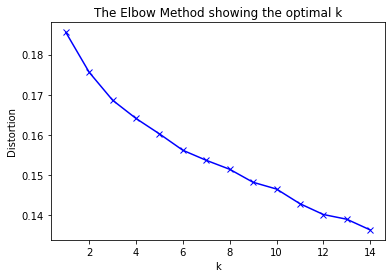

In [67]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# create new plot and data
plt.plot()
#X = np.array(list(zip(x1, x2))).reshape(len(x1), 2)
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

# k means determine k
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(Neighbourhood_venues_grouped_clustering)
    kmeanModel.fit(Neighbourhood_venues_grouped_clustering)
    distortions.append(sum(np.min(cdist(Neighbourhood_venues_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / Neighbourhood_venues_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


#### After example the result, I notice although select 14 as K, we have the best cluster result , however the purpose of the analysis is try to identify any other suburb which similar to these 4 Chinese community I have listed in the paper.  
#### finally I have selected k as 10 for this analysis.

In [68]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 10

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Neighbourhood_venues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


array([0, 2, 8, 9, 4, 5, 0, 9, 5, 5], dtype=int32)

In [69]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'cluster_label', kmeans.labels_)

Neighbourhood_venues_merged = Sydney_2beds_Geo_Rent
Neighbourhood_venues_merged = Neighbourhood_venues_merged.join(neighborhoods_venues_sorted.set_index('neighbourhood'), on='neighbourhood')

Neighbourhood_venues_merged.head() # check the last columns!

,suburb,postcode,area,neighbourhood,lat,lon,dwelling,bedroom_no,fq_rent,median_rent,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Sydney City,2000,Central & Inner Metropolitan,DAWES POINT,-33.855601,151.208220,Flat/Unit,2 Bedrooms,830.0,915.0,...,Pub,Italian Restaurant,Hotel,Australian Restaurant,Seafood Restaurant,Brewery,Boat or Ferry,Japanese Restaurant,Cocktail Bar,Chinese Restaurant
2,Sydney City,2000,Central & Inner Metropolitan,HAYMARKET,-33.880777,151.202796,Flat/Unit,2 Bedrooms,830.0,915.0,...,Thai Restaurant,Chinese Restaurant,Hotel,Coffee Shop,Japanese Restaurant,Dumpling Restaurant,Sushi Restaurant,Hostel,Ice Cream Shop,Asian Restaurant
4,Sydney City,2000,Central & Inner Metropolitan,MILLERS POINT,-33.858315,151.203519,Flat/Unit,2 Bedrooms,830.0,915.0,...,Hotel,Pub,Italian Restaurant,Australian Restaurant,Coffee Shop,Seafood Restaurant,Cocktail Bar,Brewery,Restaurant,Hotel Bar
6,Sydney City,2000,Central & Inner Metropolitan,PARLIAMENT HOUSE,-33.867229,151.213051,Flat/Unit,2 Bedrooms,830.0,915.0,...,Hotel,Hotel Bar,Shopping Mall,Steakhouse,Sandwich Place,Coffee Shop,Speakeasy,Gym,Fountain,Restaurant
8,Sydney City,2000,Central & Inner Metropolitan,SYDNEY,-33.867139,151.207114,Flat/Unit,2 Bedrooms,830.0,915.0,...,Coffee Shop,Bar,Hotel,Cocktail Bar,Speakeasy,Shopping Mall,French Restaurant,Italian Restaurant,Restaurant,Bakery


In [70]:
#example the output
Neighbourhood_venues_merged1=Neighbourhood_venues_merged.drop(columns=['postcode','area','suburb','dwelling','bedroom_no'])
Neighbourhood_venues_merged1.dropna(subset=['cluster_label'], how='all', inplace=True)
Neighbourhood_venues_merged1.cluster_label = Neighbourhood_venues_merged1.cluster_label.astype(int)
Neighbourhood_venues_merged1.head()

,neighbourhood,lat,lon,fq_rent,median_rent,tq_rent,total_bonds,annual_median_rent_change,cluster_label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,DAWES POINT,-33.855601,151.208220,830.0,915.0,1050.0,2731,-0.0343,0,Pub,Italian Restaurant,Hotel,Australian Restaurant,Seafood Restaurant,Brewery,Boat or Ferry,Japanese Restaurant,Cocktail Bar,Chinese Restaurant
2,HAYMARKET,-33.880777,151.202796,830.0,915.0,1050.0,2731,-0.0343,0,Thai Restaurant,Chinese Restaurant,Hotel,Coffee Shop,Japanese Restaurant,Dumpling Restaurant,Sushi Restaurant,Hostel,Ice Cream Shop,Asian Restaurant
4,MILLERS POINT,-33.858315,151.203519,830.0,915.0,1050.0,2731,-0.0343,0,Hotel,Pub,Italian Restaurant,Australian Restaurant,Coffee Shop,Seafood Restaurant,Cocktail Bar,Brewery,Restaurant,Hotel Bar
6,PARLIAMENT HOUSE,-33.867229,151.213051,830.0,915.0,1050.0,2731,-0.0343,0,Hotel,Hotel Bar,Shopping Mall,Steakhouse,Sandwich Place,Coffee Shop,Speakeasy,Gym,Fountain,Restaurant
8,SYDNEY,-33.867139,151.207114,830.0,915.0,1050.0,2731,-0.0343,0,Coffee Shop,Bar,Hotel,Cocktail Bar,Speakeasy,Shopping Mall,French Restaurant,Italian Restaurant,Restaurant,Bakery


### Identify the cluster which has the 4 targeted Chinese communities and then identify what other suburbs similar to these neighbourhood which can be alternative choose for tenant

In [71]:
Chinese_Neighbourhood=Neighbourhood_venues_merged1.query("neighbourhood in ('BURWOOD','CHATSWOOD','HURSTVILLE','ASHFIELD')")
Chinese_Neighbourhood

,neighbourhood,lat,lon,fq_rent,median_rent,tq_rent,total_bonds,annual_median_rent_change,cluster_label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
226,CHATSWOOD,-33.795617,151.185329,578.0,680.0,820.0,1508,0.0000,2,Chinese Restaurant,Coffee Shop,Food Court,Japanese Restaurant,Malay Restaurant,Ramen Restaurant,Sushi Restaurant,Gym,Bakery,Thai Restaurant
394,ASHFIELD,-33.889498,151.127444,450.0,490.0,550.0,2239,-0.0200,2,Dumpling Restaurant,Shanghai Restaurant,Platform,Asian Restaurant,Supermarket,Electronics Store,Chinese Restaurant,Japanese Restaurant,Thai Restaurant,Convenience Store
399,BURWOOD,-33.877423,151.103682,538.0,620.0,676.0,1106,-0.0159,8,Chinese Restaurant,Supermarket,Coffee Shop,Noodle House,Department Store,Sandwich Place,Fast Food Restaurant,Clothing Store,Other Nightlife,Shopping Mall
676,HURSTVILLE,-33.965923,151.101184,490.0,530.0,580.0,2039,0.0000,8,Chinese Restaurant,Supermarket,Fast Food Restaurant,Japanese Restaurant,Bakery,Dim Sum Restaurant,Platform,Vietnamese Restaurant,Coffee Shop,Shopping Mall


In [72]:
similar=Neighbourhood_venues_merged1.query("cluster_label in (2,8)").sort_values(by="cluster_label")
similar

,neighbourhood,lat,lon,fq_rent,median_rent,tq_rent,total_bonds,annual_median_rent_change,cluster_label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,SYDNEY SOUTH,-33.877718,151.205723,830.0,915.0,1050.0,2731,-0.0343,2,Thai Restaurant,Japanese Restaurant,Chinese Restaurant,Hotel,Coffee Shop,Korean Restaurant,Burger Joint,Ice Cream Shop,Sushi Restaurant,Hostel
659,KOGARAH,-33.963107,151.133462,435.0,478.0,535.0,2018,-0.0450,2,Thai Restaurant,Pub,Sandwich Place,Lebanese Restaurant,Coffee Shop,Chinese Restaurant,Shopping Mall,Bakery,Convenience Store,Supermarket
651,BRIGHTON-LE-SANDS,-33.960538,151.155362,450.0,495.0,555.0,2309,-0.0100,2,Dessert Shop,Pizza Place,Coffee Shop,Greek Restaurant,Thai Restaurant,Italian Restaurant,Mediterranean Restaurant,Fast Food Restaurant,Seafood Restaurant,Park
394,ASHFIELD,-33.889498,151.127444,450.0,490.0,550.0,2239,-0.0200,2,Dumpling Restaurant,Shanghai Restaurant,Platform,Asian Restaurant,Supermarket,Electronics Store,Chinese Restaurant,Japanese Restaurant,Thai Restaurant,Convenience Store
381,EPPING,-33.772549,151.082365,515.0,560.0,590.0,1558,-0.0345,2,Indian Restaurant,Thai Restaurant,Metro Station,Pizza Place,Liquor Store,Social Club,BBQ Joint,Sandwich Place,Coffee Shop,Supermarket
362,WEST RYDE,-33.807712,151.088724,390.0,420.0,580.0,1655,-0.0870,2,Japanese Restaurant,Supermarket,Gym,Breakfast Spot,BBQ Joint,Sports Bar,Shopping Mall,Bookstore,Miscellaneous Shop,Chinese Restaurant
279,NEUTRAL BAY JUNCTION,-33.831529,151.222401,595.0,650.0,710.0,1199,-0.0511,2,Japanese Restaurant,Thai Restaurant,Gym,Supermarket,Pharmacy,Bakery,Malay Restaurant,Burger Joint,German Restaurant,Seafood Restaurant
277,NEUTRAL BAY,-33.831120,151.221232,595.0,650.0,710.0,1199,-0.0511,2,Japanese Restaurant,Thai Restaurant,Supermarket,Gym,Burger Joint,Malay Restaurant,Pharmacy,Bakery,Convenience Store,Bus Station
275,SPIT JUNCTION,-33.822964,151.242292,560.0,630.0,750.0,1433,-0.0455,2,Japanese Restaurant,Convenience Store,Toy / Game Store,Pub,Deli / Bodega,Electronics Store,Coffee Shop,Shopping Mall,Supermarket,Greek Restaurant
232,NORTH WILLOUGHBY,-33.793089,151.195787,505.0,575.0,620.0,354,-0.0254,2,Japanese Restaurant,Bakery,Pizza Place,Italian Restaurant,Asian Restaurant,Fast Food Restaurant,Grocery Store,BBQ Joint,Thai Restaurant,Fruit & Vegetable Store


## Result map which shows all neighbourhood that similar to the neighbourhood that linked to the Chinese Community

In [73]:
Neighbourhood_venues_merged2=Neighbourhood_venues_merged1.query("cluster_label in (2,8)")

import matplotlib.cm as cm
import matplotlib.colors as colors

address = 'Sydney, Australia'

#-33.876295,151.1985883,

geolocator = Nominatim(user_agent="sydney_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude



# create map
map_clusters2 = folium.Map(width=2000,height=2000,location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Neighbourhood_venues_merged2['lat'], Neighbourhood_venues_merged2['lon'], Neighbourhood_venues_merged2['neighbourhood'], Neighbourhood_venues_merged2['cluster_label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2

##  Below are feature Selection section which is a test I have performed during this analysis, not linked to above analysis and I have added it here for my future reference

#!conda install -c anaconda xlrd --yes
#$ pip install feature-selector
#pip install numpy --upgrade

from feature_selector import FeatureSelector
fs = FeatureSelector(data = Neighbourhood_rent_venue, labels = Neighbourhood_rent_venue['median_rent'])
fs.identify_missing(missing_threshold = 0.01)
fs.identify_collinear(correlation_threshold = 0.5)
collinear_features = fs.ops['collinear']
fs.record_collinear.head()
fs.plot_collinear()
# Pass in the appropriate parameters
fs.identify_zero_importance(task = 'regression', 
                            eval_metric = 'auc', 
                            n_iterations = 10, 
                             early_stopping = True)
# list of zero importance features
zero_importance_features = fs.ops['zero_importance']
# plot the feature importances
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)